In [12]:
import pandas as pd
from stock_screening_local import *
import pickle

In [2]:
ticker_info = pd.read_csv('yahoo_tickers.csv')
all_tickers = ticker_info['Ticker'].tolist()
all_tickers.sort()

In [ ]:
ticker_ratios = {ticker: {} for ticker in all_tickers}
for i, ticker in enumerate(all_tickers):
    print(i, ticker)
    ticker_ratios[ticker] = {'quick_ratio': quick_ratio(ticker, latest=True, period=-1),
                             'cash_ratio': cash_ratio(ticker, latest=True, period=-1),
                             'operating_cash_ratio': operating_cash_ratio(ticker, latest=True, period=-1),
                             'interest_coverage_ratio': interest_coverage_ratio(ticker, latest=True, period=-1),
                             'debt_service_coverage_ratio': debt_service_coverage_ratio(ticker, latest=True, period=-1),
                             'asset_coverage_ratio': asset_coverage_ratio(ticker, latest=True, period=-1),
                             'cash_coverage_ratio': cash_coverage_ratio(ticker, latest=True, period=-1),
                             'total_debt_to_tangible_book_value_ratio': total_debt_to_tangible_book_value_ratio(ticker, latest=True, period=-1),
                             'total_debt_to_total_assets_ratio': total_debt_to_total_assets_ratio(ticker, latest=True, period=-1),
                             'total_debt_to_EBITDA_ratio': total_debt_to_EBITDA_ratio(ticker, latest=True, period=-1)}
    if all([v is not None for v in ticker_ratios[ticker].values()]):
        print(f'{i} {ticker} PASSED!')
with open('ticker_ratios.pickle', 'wb') as f:
    pickle.dump(ticker_ratios, f)

In [4]:
with open('output.txt', 'r') as f:
    lines = f.read().splitlines()
missing_fields = {}
for line in lines:
    field = line.split(': ')[-1]
    if field.startswith('\'') and field.endswith('\'') and 'NoneType' not in field:
        try:
            missing_fields[field] += 1
        except KeyError:
            missing_fields[field] = 1
missing_fields = {k: missing_fields[k] for k in sorted(missing_fields.keys(), key=missing_fields.get, reverse=True)}
missing_fields

{"'annualEBITDA'": 1089,
 "'annualCurrentLiabilities'": 648,
 "'annualTotalNonCurrentLiabilitiesNetMinorityInterest'": 648,
 "'annualInventory'": 409,
 "'annualDepreciationAmortizationDepletion'": 357,
 "'annualAmortizationOfSecurities'": 331,
 "'annualCurrentDebt'": 258,
 "'annualOperatingIncome'": 220,
 "'annualInterestExpense'": 168,
 "'annualInterestExpenseNonOperating'": 168,
 "'annualCurrentAssets'": 151,
 "'annualTotalNonCurrentAssets'": 151,
 "'annualLongTermDebt'": 142,
 "'annualEBIT'": 141,
 "'annualTotalOtherFinanceCost'": 132,
 "'annualGoodwillAndOtherIntangibleAssets'": 96,
 "'annualReconciledDepreciation'": 64,
 "'annualTotalDebt'": 64,
 "'annualNormalizedEBITDA'": 16}

In [3]:
with open('ticker_ratios.pickle', 'rb') as f:
    ticker_ratios = pickle.load(f)

In [5]:
missing_ratios_count = {}
for ratios in ticker_ratios.values():
    for ratio, value in ratios.items():
        if value is None:
            try:
                missing_ratios_count[ratio] += 1
            except KeyError:
                missing_ratios_count[ratio] = 1

missing_ratios_count = {k: missing_ratios_count[k] for k in sorted(missing_ratios_count.keys(), key=missing_ratios_count.get, reverse=True)}
missing_ratios_count

{'quick_ratio': 132,
 'asset_coverage_ratio': 110,
 'debt_service_coverage_ratio': 64,
 'cash_ratio': 55,
 'operating_cash_ratio': 55,
 'cash_coverage_ratio': 14,
 'interest_coverage_ratio': 11,
 'total_debt_to_EBITDA_ratio': 6,
 'total_debt_to_tangible_book_value_ratio': 4,
 'total_debt_to_total_assets_ratio': 4}

In [6]:
for ticker, ratios in ticker_ratios.items():
    if ratios['total_debt_to_EBITDA_ratio'] is None:
        print(ticker)

0939.HK
BBSE3.SA
DB
GMED
HTLD
MNST


In [7]:
def pass_ratio(ticker, ratio, higher_better=True) -> bool:  # return whether pass or not
    # Data below taken from 2022 Q2 on https://csimarket.com/Industry/Industry_Data.php
    sector_mean_ratios = {'Consumer Discretionary': {'quick_ratio': 0.44, 'interest_coverage_ratio': 14, 'debt_service_coverage_ratio': 1.99},  # Consumer Discretionary
                     'Financials': {'quick_ratio': 0.73, 'interest_coverage_ratio': 4.45, 'debt_service_coverage_ratio': 1.64},  # Financials
                     'Industrials': {'quick_ratio': 0.32, 'interest_coverage_ratio': 15.08, 'debt_service_coverage_ratio': 4.89},  # Capital Goods
                     'Consumer Staples': {'quick_ratio': 0.24, 'interest_coverage_ratio': 13.66, 'debt_service_coverage_ratio': 7.555},  # avg of Consumer Non Cyclical and Retail
                     'Information Technology': {'quick_ratio': 0.84, 'interest_coverage_ratio': 37.21, 'debt_service_coverage_ratio': 8.64},  # Technology
                     'Health Care': {'quick_ratio': 0.76, 'interest_coverage_ratio': 13.06, 'debt_service_coverage_ratio': 4.99},  # Healthcare
                     'Materials': {'quick_ratio': 0.35, 'interest_coverage_ratio': 19.28, 'debt_service_coverage_ratio': 7.38},  # Basic materials
                     'Communication Services': {'quick_ratio': 0.26, 'interest_coverage_ratio': 9.15, 'debt_service_coverage_ratio': 3.5},
                     'Utilities': {'quick_ratio': 0.14, 'interest_coverage_ratio': 6.05, 'debt_service_coverage_ratio': 2},  # Utilities
                     'Energy': {'quick_ratio': 0.24, 'interest_coverage_ratio': 23.36, 'debt_service_coverage_ratio': 16.49},  # Energy
                     'Real Estate': {'quick_ratio': 0.93, 'interest_coverage_ratio': 7.21, 'debt_service_coverage_ratio': 4.87}}  # Real Estate Operations

    ratio_value = ticker_ratios[ticker][ratio]
    if ratio_value is None:  # allow BOD
        return True
    ticker_sector = ticker_info.loc[ticker_info['Ticker'] == ticker]['GICS Sector'].to_list()[0]
    if ratio in sector_mean_ratios['Energy'].keys():  # 'energy is just example, no specific meaning
        return ratio_value >= sector_mean_ratios[ticker_sector][ratio] if higher_better else ratio_value <= sector_mean_ratios[ticker_sector][ratio]
    else:
        same_sector_tickers = ticker_info[ticker_info['GICS Sector'] == ticker_sector]['Ticker'].to_list()
        ratios = [ticker_ratios[ticker][ratio] for ticker in same_sector_tickers if ticker_ratios[ticker][ratio] is not None]  # TODO: see what to do to handle None values, for now just ignore
        ratios.append(ratio_value)
        ratios.sort()  # ascending
        percentile = ratios.index(ratio_value) / len(ratios) * 100  # top x percentile
        return percentile >= 50 if higher_better else percentile <= 50

def screen_stock(ticker: str) -> bool:
    ticker = ticker.upper()
    z_score = altman_z_score(ticker, latest=True, period=-1)
    if z_score is not None and z_score <= 1.1:  # allow BOD
        return False

    # Ratios {ratio name: higher better}
    key_ratios = {'quick_ratio': True, 'debt_service_coverage_ratio': True, 'total_debt_to_total_assets_ratio': False}  # must pass
    normal_ratios = {'cash_ratio': True, 'operating_cash_ratio': True, 'interest_coverage_ratio': True, 'asset_coverage_ratio': True, 'cash_coverage_ratio': True, 'total_debt_to_tangible_book_value_ratio': False, 'total_debt_to_EBITDA_ratio': False}
    passed_ratio_count = 0
    liquidity = False
    coverage = False
    leverage = False
    liquidity_ratios = ['quick_ratio', 'cash_ratio', 'operating_cash_ratio']
    coverage_ratios = ['interest_coverage_ratio', 'debt_service_coverage_ratio', 'asset_coverage_ratio', 'cash_coverage_ratio']
    leverage_ratios = ['total_debt_to_tangible_book_value_ratio', 'total_debt_to_total_assets_ratio', 'total_debt_to_EBITDA_ratio']
    for ratio, higher_better in key_ratios.items():
        if pass_ratio(ticker, ratio, higher_better):
            passed_ratio_count += 1
            liquidity = ratio in liquidity_ratios if not liquidity else True
            coverage = ratio in coverage_ratios if not coverage else True
            leverage = ratio in leverage_ratios if not leverage else True
        else:
            return False  # must pass all key ratios
    for ratio, higher_better in normal_ratios.items():
        if pass_ratio(ticker, ratio, higher_better):
            passed_ratio_count += 1
            liquidity = ratio in liquidity_ratios if not liquidity else True
            coverage = ratio in coverage_ratios if not coverage else True
            leverage = ratio in leverage_ratios if not leverage else True
    if passed_ratio_count < 6 or not (liquidity and coverage and leverage):  # must pass 6/10 ratios and at least 1 in each category
        return False

    # F-score
    f_score = F_score(ticker, latest=True, period=-1)
    if f_score is not None and f_score < 6:  # F score need to be >= 6 to pass, allow BOD
        return False
    return True

In [8]:
%%capture cap --no-stderr  # to disable output
passed_stocks = [ticker for ticker in all_tickers if screen_stock(ticker)]

In [10]:
with open('passed.txt', 'w+') as f:
    f.write('\n'.join(passed_stocks))
passed_stocks

['000333.SZ',
 '000858.SZ',
 '0384.HK',
 '0914.HK',
 '300760.SZ',
 '600007.SS',
 '600519.SS',
 'ABT',
 'AFL',
 'ALL',
 'AMD',
 'AMZN',
 'ARCB',
 'ATD.TO',
 'BABA',
 'BBSE3.SA',
 'BHP.L',
 'BLK',
 'CASY',
 'CIPLA.BO',
 'CJT.TO',
 'CLIG.L',
 'COST',
 'CTSH',
 'CTVA',
 'CVX',
 'DJCO',
 'DRREDDY.BO',
 'ECLERX.BO',
 'ELET3.SA',
 'ENGH.TO',
 'FCN',
 'FCX',
 'FFH.TO',
 'FFHL',
 'FIZZ',
 'FTNT',
 'GOOG',
 'GRMN',
 'GWO.TO',
 'HCLTECH.BO',
 'HDFCBANK.BO',
 'HSBA.L',
 'HTLD',
 'ICICIBANK.BO',
 'INFY.BO',
 'ITC.BO',
 'JJSF',
 'JPM',
 'LLOY.L',
 'LMT',
 'LULU',
 'MANH',
 'MET',
 'META',
 'MOV',
 'MSFT',
 'MTB',
 'NESTLEIND.BO',
 'NFLX',
 'NIITLTD.BO',
 'NOC',
 'NTES',
 'NVS',
 'ONB',
 'PFE',
 'PG',
 'PNC',
 'PRU',
 'RF',
 'RGLD',
 'RIO.L',
 'SBIN.BO',
 'SDR.L',
 'SEIC',
 'SSE.L',
 'SUNPHARMA.BO',
 'SWBI',
 'TCS.BO',
 'TM',
 'TR',
 'TREX',
 'TROW',
 'TSLA',
 'TSN',
 'TXRH',
 'UAA',
 'UGI',
 'ULTA',
 'ULTRACEMCO.BO',
 'UNH',
 'VALE3.SA',
 'VEEV',
 'WDFC',
 'WMT',
 'WSM',
 'WYN.L',
 'XOM',
 'ZTO']

In [11]:
with open('passed.txt', 'r') as f:
    passed_stocks = f.read().splitlines()

In [24]:
import yfinance as yf
esg_env_scores = {}
for i, ticker in enumerate(passed_stocks):
    print(i, ticker)
    ticker = yf.Ticker(ticker)
    sus = ticker.sustainability
    if sus is not None:
        sus = sus.to_dict()['Value']
        if 'environmentScore' in sus:
            esg_env_scores[ticker.ticker] = sus['environmentScore']
    else:
        esg_env_scores[ticker.ticker] = None

0 000333.SZ
1 000858.SZ
2 0384.HK
3 0914.HK
4 300760.SZ
5 600007.SS
6 600519.SS
7 ABT
8 AFL
9 ALL
10 AMD
11 AMZN
12 ARCB
13 ATD.TO
14 BABA
15 BBSE3.SA
16 BHP.L
17 BLK
18 CASY
19 CIPLA.BO
20 CJT.TO
21 CLIG.L
22 COST
23 CTSH
24 CTVA
25 CVX
26 DJCO
27 DRREDDY.BO
28 ECLERX.BO
29 ELET3.SA
30 ENGH.TO
31 FCN
32 FCX
33 FFH.TO
34 FFHL
35 FIZZ
36 FTNT
37 GOOG
38 GRMN
39 GWO.TO
40 HCLTECH.BO
41 HDFCBANK.BO
42 HSBA.L
43 HTLD
44 ICICIBANK.BO
45 INFY.BO
46 ITC.BO
47 JJSF
48 JPM
49 LLOY.L
50 LMT
51 LULU
52 MANH
53 MET
54 META
55 MOV
56 MSFT
57 MTB
58 NESTLEIND.BO
59 NFLX
60 NIITLTD.BO
61 NOC
62 NTES
63 NVS
64 ONB
65 PFE
66 PG
67 PNC
68 PRU
69 RF
70 RGLD
71 RIO.L
72 SBIN.BO
73 SDR.L
74 SEIC
75 SSE.L
76 SUNPHARMA.BO
77 SWBI
78 TCS.BO
79 TM
80 TR
81 TREX
82 TROW
83 TSLA
84 TSN
85 TXRH
86 UAA
87 UGI
88 ULTA
89 ULTRACEMCO.BO
90 UNH
91 VALE3.SA
92 VEEV
93 WDFC
94 WMT
95 WSM
96 WYN.L
97 XOM
98 ZTO


In [26]:
import orjson as json
with open('ticker_esg.json', 'w+') as f:
    f.write(json.dumps(esg_env_scores).decode('utf-8'))

In [43]:
with open('ticker_esg.json', 'r') as f:
    esg_env_scores = json.loads(f.read())

(array([ 7., 18.,  8.,  4.,  2.,  3.,  0.,  2.,  1.,  0.,  2.,  2.,  0.,
         1.,  1.,  3.,  1.,  2.,  1.,  3.]),
 array([ 0.03 ,  0.959,  1.888,  2.817,  3.746,  4.675,  5.604,  6.533,
         7.462,  8.391,  9.32 , 10.249, 11.178, 12.107, 13.036, 13.965,
        14.894, 15.823, 16.752, 17.681, 18.61 ]),
 <BarContainer object of 20 artists>)

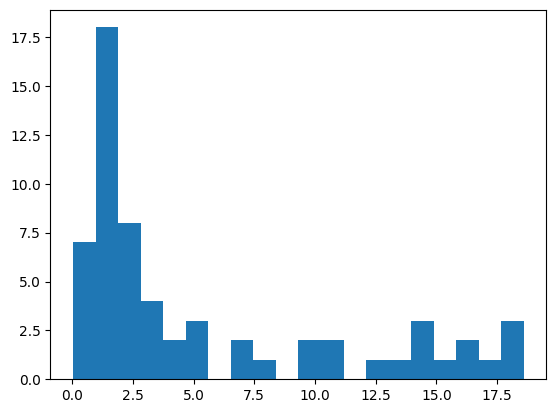

In [44]:
from matplotlib import pyplot as plt
env_scores = [float(score) for score in esg_env_scores.values() if score]
plt.hist(env_scores, bins=20)

In [45]:
# esg_env_scores = {k: v for k, v in esg_env_scores.items() if v}
# esg_env_scores = {k: esg_env_scores[k] for k in sorted(esg_env_scores.keys(), key=esg_env_scores.get, reverse=True)}
esg_env_scores = {k: v for k, v in esg_env_scores.items() if v is None or v<10}
esg_env_scores

{'000333.SZ': None,
 '000858.SZ': None,
 '300760.SZ': None,
 '600007.SS': None,
 'ABT': 3.03,
 'AFL': 0.47,
 'ALL': 1.44,
 'AMD': None,
 'AMZN': 5.59,
 'ARCB': None,
 'BABA': None,
 'BBSE3.SA': 0.07,
 'BLK': 1.49,
 'CASY': None,
 'CIPLA.BO': 2.1,
 'CJT.TO': None,
 'CLIG.L': None,
 'COST': 7.26,
 'CTSH': 1.11,
 'CTVA': None,
 'DJCO': None,
 'DRREDDY.BO': 1.7,
 'ECLERX.BO': None,
 'ELET3.SA': None,
 'ENGH.TO': None,
 'FCN': None,
 'FFH.TO': 2.33,
 'FFHL': None,
 'FIZZ': None,
 'FTNT': 1.23,
 'GOOG': None,
 'GRMN': 5.4,
 'GWO.TO': 2.25,
 'HCLTECH.BO': 1.02,
 'HDFCBANK.BO': 2.08,
 'HSBA.L': 1.16,
 'HTLD': None,
 'ICICIBANK.BO': 3.1,
 'INFY.BO': 1.07,
 'ITC.BO': 6.83,
 'JJSF': None,
 'JPM': 1.11,
 'LLOY.L': 0.6,
 'LMT': 5.27,
 'LULU': 1.62,
 'MANH': None,
 'MET': 0.73,
 'META': 1.02,
 'MOV': None,
 'MSFT': 1.53,
 'MTB': 2.2,
 'NFLX': 0.09,
 'NIITLTD.BO': None,
 'NOC': 7.47,
 'NTES': None,
 'NVS': None,
 'ONB': None,
 'PFE': 2.83,
 'PG': 9.54,
 'PNC': 1.73,
 'PRU': 1.03,
 'RF': 1.6,
 'RGLD':